# Librairies

In [83]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import ipywidgets as widgets
import re
from collections import OrderedDict
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from optuna.integration.mlflow import MLflowCallback
import random
from argparse import Namespace
import mlflow
from pathlib import Path
import joblib
import tempfile
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support
import optuna
from numpyencoder import NumpyEncoder
import warnings
warnings.filterwarnings("ignore")


# Configuration & Loading

In [84]:
path_data = '../../datasets/twitter-finance/tweet_data.csv'
path_tags = '../../datasets/twitter-finance/tags.txt'

# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

seed = 42

NUM_TRIALS = 2


In [85]:
def set_seed(seed = 42):
    np.random.seed(seed)
    random.seed(seed)

set_seed(seed)

In [86]:
df = pd.read_csv(path_data)
df.head()

,text,label
0,Here are Thursday's biggest analyst calls: App...,Analyst Update
1,Buy Las Vegas Sands as travel to Singapore bui...,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, cit...",Analyst Update
3,"Analysts react to Tesla's latest earnings, bre...",Analyst Update
4,Netflix and its peers are set for a ‘return to...,Analyst Update


# Exploratory Data Analaysis & Pre Processing

## Tag processing (Optional)

In [87]:
# def idx_tag(path_file): # TODO : OPTIMIZE
#     dict_tags = dict()
#     with open(path_file, 'r') as f:
#         lines = f.readlines()
#         for line in lines:
#             if line != '\n':
#                 key_value = line.split(':')
#                 key = int(key_value[0].split('_')[-1][:-1])
#                 value = line.split(':')[1].replace('\n', '')
#                 dict_tags[key] = value.replace('"', '')[1:]
#     return dict_tags

In [88]:
# dict_tags = idx_tag(path_tags)
# dict_tags

In [89]:
# def idx_to_tag(serie, dict_tags):
#     return serie.apply(lambda x : dict_tags[x])

In [90]:
# df.label = idx_to_tag(df.label, dict_tags)
# df.head()

In [91]:
# df.to_csv(path_data, index= False) #Save with tags not labels

## 1st Distribution Analysis

- Distribution of tags categories
- Wordcloud of most common words

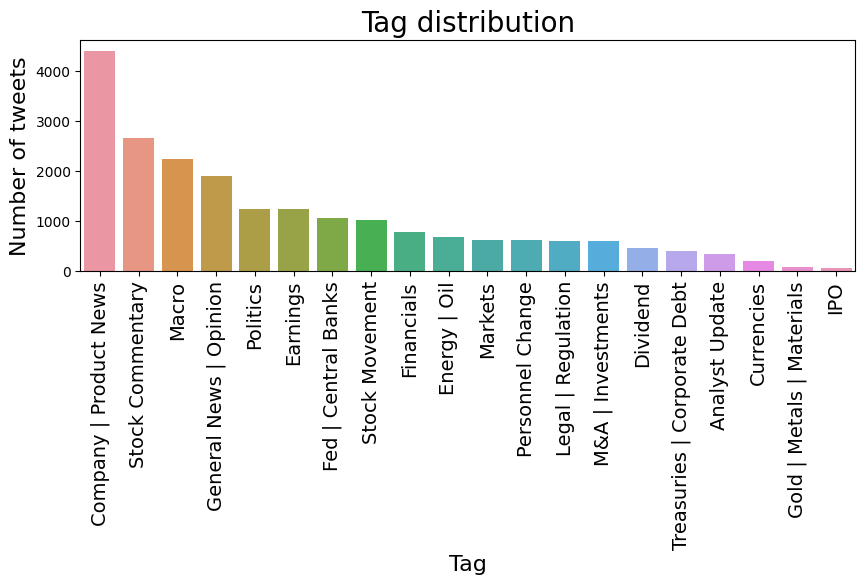

In [92]:
def plot_tag_distribution(df):
    plt.figure(figsize=(10, 3))
    tags, tag_counts = zip(*Counter(df.label.values).most_common()) #most_common : items but sorted
    ax = sns.barplot(x = list(tags), y = list(tag_counts))
    plt.title("Tag distribution", fontsize=20)
    plt.xlabel("Tag", fontsize=16)
    ax.set_xticklabels(tags, rotation=90, fontsize=14)
    plt.ylabel("Number of tweets", fontsize=16)
    plt.show()
    
    return tags, tag_counts

train_tags, train_tag_counts = plot_tag_distribution(df)

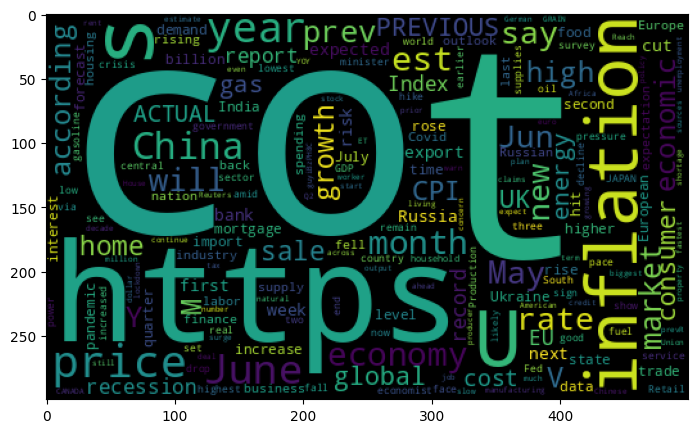

In [93]:
def plot_tag_wordcloud(df, tag):
    plt.figure(figsize=(15, 5))
    filtered_df = df[df.label == tag]
    text = filtered_df.text.values

    cloud = WordCloud(stopwords = STOPWORDS, background_color="black", 
                      collocations=False, width=500, height=300).generate(" ".join(text))
    
    plt.imshow(cloud)
    plt.show()

plot_tag_wordcloud(df, "Macro")
    

## Clean Text

- Stopwords
- Capitalize & Lowerize
- Links
- Filters & Spacing

In [94]:
stemmer = PorterStemmer()
STOPWORDS = stopwords.words("english")
def clean_text(text, lower = False, stem= False, stopwords = STOPWORDS, stemmer = stemmer):
    # Lower
    if lower:
        text = text.lower()

    # Remove links
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", text)

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

raw_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)

## 2nd Distribution Analysis

- WordCloud of most common words

In [134]:
dict_df = {
    'clean' : df,
    'raw' : raw_df
}

@widgets.interact(df_key = list(dict_df.keys()), tag = list(train_tags))
def plot_tag_wordcloud(df_key = 'clean', tag = 'Macro'):
    plt.figure(figsize=(15, 5))

    df = dict_df[df_key]

    filtered_df = df[df.label == tag]
    text = filtered_df.text.values

    cloud = WordCloud(stopwords = STOPWORDS, background_color="black", 
                      collocations=False, width=500, height=300).generate(" ".join(text))
    
    plt.imshow(cloud)
    plt.show()

interactive(children=(Dropdown(description='df_key', options=('clean', 'raw'), value='clean'), Dropdown(descri…

## Tag filtering 

- Labels not relevant for our use case 
- Unbalanced

In [96]:
# Accepted tags (external/business constraint)
ACCEPTED_TAGS = ['Company | Product News', 'Stock Commentary', 'Macro', 'General News | Opinion', 'Stock Movement', 'M&A | Investments']
# Out of scope (OOS) tags
oos_tags = [item for item in train_tags if item not in ACCEPTED_TAGS]
oos_tags ## will be classified as others

['Politics',
 'Earnings',
 'Fed | Central Banks',
 'Financials',
 'Energy | Oil',
 'Markets',
 'Personnel Change',
 'Legal | Regulation',
 'Dividend',
 'Treasuries | Corporate Debt',
 'Analyst Update',
 'Currencies',
 'Gold | Metals | Materials',
 'IPO']

In [97]:
df.label = df.label.apply(lambda x: "other" if x in oos_tags else x)

In [98]:
# Minimum frequency required for a tag
min_freq = 750
train_tags = Counter(df.label.values)

# Tags that just made / missed the cut
@widgets.interact(min_freq=(0, train_tags.most_common()[0][1]))
def separate_tags_by_freq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in train_tags.elements()
                                    if train_tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in train_tags.elements()
                                    if train_tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=750, description='min_freq', max=8327), Output()), _dom_classes=('widget…

In [99]:
def preprocess(df, lower, stem, min_freq):
    """Preprocess the data."""
    df.text = df.text.apply(clean_text, lower=lower, stem=stem)  # clean text

    # Replace OOS tags with `other`
    oos_tags = [item for item in df.label.unique() if item not in ACCEPTED_TAGS]
    df.label = df.label.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags = Counter(df.label.values)
    tags_above_freq = Counter(tag for tag in tags.elements() 
                            if (tags[tag] >= min_freq))
    df.label = df.label.apply(lambda tag: tag if tag in tags_above_freq else "other")

    return df

In [100]:
dict_df = {
    'processed' : preprocess(df, lower=True, stem=False, min_freq=min_freq),
    'raw' : raw_df
}

@widgets.interact(df_key = list(dict_df.keys()))
def plot_tag_distri(df_key = 'processed'):
    plt.figure(figsize=(10, 3))
    df = dict_df[df_key]
    tags, tag_counts = zip(*Counter(df.label.values).most_common()) #most_common : items but sorted
    ax = sns.barplot(x = list(tags), y = list(tag_counts))
    plt.title("Tag distribution", fontsize=20)
    plt.xlabel("Tag", fontsize=16)
    ax.set_xticklabels(tags, rotation=90, fontsize=14)
    plt.ylabel("Number of tweets", fontsize=16)
    plt.show()

interactive(children=(Dropdown(description='df_key', options=('processed', 'raw'), value='processed'), Output(…

## Label Encoding

- Encode tags to unique integer indices

In [101]:
class LabelEncoder:
    def __init__(self, tag_to_idx = {}) -> None:
        self.tag_to_idx = {} or tag_to_idx
        self.idx_to_tag = {v:k for k,v in self.tag_to_idx.items()}
        self.tags = list(self.tag_to_idx.keys())
        self.indices = list(self.idx_to_tag.keys())


    def __len__(self) -> int:
        return len(self.tags)

    def __str__(self) -> str:
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        tags = np.unique(y)
        for i, tag in enumerate(tags):
            self.tag_to_idx[tag] = i
        self.idx_to_tag = {v:k for k,v in self.tag_to_idx.items()}
        self.tags = list(self.tag_to_idx.keys())
        self.indices = list(self.idx_to_tag.keys())

        return self

    def encode(self, y):
        return [self.tag_to_idx[tag] for tag in y]
    
    def decode(self, y):
        return [self.idx_to_tag[idx] for idx in y] 

    def save(self, file_path):
        with open(file_path, 'w') as f:
            contents = {"tag_to_idx" : self.tag_to_idx}
            json.dump(contents, f, indent=4, sort_keys = False)

    @classmethod 
    def load(cls, file_path):
        with open(file_path, 'r') as f:
            kwargs = json.load(fp=f)
        return cls(**kwargs)

In [102]:
df = preprocess(df, lower = True, stem = False, min_freq = 750)

X = df.text.to_numpy()
y = df.label

label_encoder = LabelEncoder()
label_encoder.fit(y)
print(label_encoder.tag_to_idx)

y = label_encoder.encode(y)

{'Company | Product News': 0, 'General News | Opinion': 1, 'Macro': 2, 'Stock Commentary': 3, 'Stock Movement': 4, 'other': 5}


# Splitting

- Train split : 
Train the model 
- Validation split : 
After each loop (epoch) of the training split, used to determine model performance.
- Test split :
After training stops (epoch(s)), used to perform a one-time assessment of the model.

Note : 
1. The dataset (and each data split) should be representative of data we will encounter
2. Equal distributions of output values across all splits
3. Shuffle your data if it's organized in a way that prevents input variance
4. Avoid random shuffles if your task can suffer from data leaks (ex. time-series)


In [103]:
def get_data_splits(X, y):
    """Generate balanced data splits."""
    # Stratify ensure that each data split has similar class distributions (2.)
    
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)

    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [104]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(X, y)


In [105]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 14774 (0.70)
val: 3166 (0.15)
test: 3167 (0.15)


In [106]:
# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.tags}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.tags}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.tags}

In [107]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,Company | Product News,General News | Opinion,Macro,Stock Commentary,Stock Movement,other
train,3078,1325,1566,1852,714,6239
val,659,284,336,397,153,1337
test,660,284,335,397,153,1338


In [108]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [109]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,Company | Product News,General News | Opinion,Macro,Stock Commentary,Stock Movement,other
train,3078,1325,1566,1852,714,6239
val,3075,1325,1568,1852,714,6239
test,3080,1325,1563,1852,714,6244


In [110]:
# Standard deviation : how much deviance there is in our naive data splits
np.mean(np.std(dist_df.to_numpy(), axis=0))

1.0777719898779683

In [111]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "label": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "label": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "label": label_encoder.decode(y_test)})
train_df.head()

,text,label
0,gates foundation plans 50 increase annual spen...,Company | Product News
1,sonatervj futures market pricing 3 25 3 50 eoy...,Macro
2,libya noc subsidiary mellitah says production ...,Macro
3,china government usually gets wants made beiji...,General News | Opinion
4,mueller industries inc reports second quarter ...,other


# Data Augmentation (Optional)

## General Processus

1. Split the dataset :
Many augmentation techniques will cause a form of data leak (ex. generating synonyms)
2. Augment **only** the training split :
Validation and testing splits should be used to provide an accurate estimate on actual data points.
3. Inspect and validate : 
useless to augment just for the sake of increasing our training sample size if the augmented data samples are not probable inputs that our model could encounter in production.

- General: 
normalization, smoothing, random noise, synthetic oversampling (SMOTE), etc.
- Natural language processing (NLP): 
substitutions (synonyms, tfidf, embeddings, masked models), random noise, spelling errors, etc.
- Computer vision (CV): 
crop, flip, rotate, pad, saturate, increase brightness, etc.

> Transformations on some data modalities may introduce silent errors (ex. shifting tokens order). It’s important to measure the noise that our augmentation policies will introduce and do have granular control over the transformations that take place.

## NLP

- NLPAug: data augmentation for NLP.
- TextAttack: a framework for adversarial attacks, data augmentation, and model training in NLP.
- TextAugment: text augmentation library.

### Substitution

Substitution doesn't seem like a great idea for us because there are certain keywords that provide strong signal for our tags so we don't want to alter those. Also, note that these augmentations are NOT deterministic and will vary every time we run them.

### Insertion 

A little better but still quite fragile and now it can potentially insert key words that can influence false positive tags to appear.

### Swapping machine learning related keywords with their aliases

> For now, we'll skip the data augmentation because it's quite fickle and empirically it doesn't improvement performance much. But we can see how this can be very effective once we can control what type of vocabulary to augment on and what exactly to augment with.

# Modelisation

## Baselines

### Presentation

Here is the high level approach to establishing baselines

1. Start with the simplest possible baseline to compare subsequent development with.
2. Develop a rule-based approach (when possible) using IFTTT, auxiliary data, etc.
3. Slowly add complexity by addressing limitations and motivating representations and model architectures.
4. Weigh tradeoffs (performance, latency, size, etc.) between performant baselines.
5. Revisit and iterate on baselines as your dataset grows.

Tradeoffs to consider :

- performance: consider coarse-grained and fine-grained (ex. per-class) performance.
- latency: how quickly does your model respond for inference.
- size: how large is your model and can you support it's storage.
- compute: how much will it cost ($, carbon footprint, etc.) to train your model?
- interpretability: does your model need to explain its predictions?
- bias checks: does your model pass key bias checks?
- time to develop: how long do you have to develop the first version?
- time to retrain: how long does it take to retrain your model? This is very important to consider if you need to retrain often.
- maintenance overhead: who and what will be required to maintain your model versions because the real work with ML begins after deploying v1. You can't just hand it off to your site reliability team to maintain it like many teams do with traditional software.

Ours benchmark : 

1. Random prediction
2. Deterministic rule-based prediction
3. Machine Learning

> Simplicity pave the way for iterative development ! We can achieve decent performance with minimal initial effort.
- Rapid experimentation via hyperparameter tuning thanks to low model complexity.
- Discovery of data issues, false assumptions, bugs in code, etc. since model itself is not complex.

### Experiment Tracking

In the past, data scientist have been training and evaluating different baselines but haven't really been tracking these experiments.
It's a really bad practice when it comes to experimentation. You can't present a brief overview of your work and the best baseline to deploy when you don't keep track of the differents metrics, models, pipelines or even data been used to generate the results. 

Experiment tracking is the process of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to :

1. Organize all the necessary components of a specific experiment.
2. Reproduce past results (easily) using saved experiments.
3. Log iterative improvements across time, data, ideas, teams, etc.

In [112]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))
# Set experiment
mlflow.set_experiment(experiment_name="baselines")

<Experiment: artifact_location='file:///media/reinstate/MyData/code/mlops-finance/notebooks/experiments/702143698702020301', creation_time=1681140692578, experiment_id='702143698702020301', last_update_time=1681140692578, lifecycle_stage='active', name='baselines', tags={}>

In [113]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)

### Random

- motivation: 
We want to know what random (chance) performance looks like. All of our efforts should be well above this baseline.

- limitations: 
We didn't use the tokens in our input to affect our predictions so nothing was learned.


In [114]:
def train_random(args):
    #set up
    set_seed(args.seed)
    df = pd.read_csv(args.path_data)
    df = preprocess(df, lower=args.lower, stem=args.stem, min_freq=args.min_freq)
    label_encoder = LabelEncoder().fit(df.label)
    _,_,_,_,_, y_test = \
        get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.label))
    
    # Generate random predictions
    #Tirage uniforme si None, sinon tirage selon les poids de p
    p = [Counter(y_test)[index]/len(y_test) for index in label_encoder.indices] if args.use_proba else None

    y_pred = np.random.choice(label_encoder.indices, size = len(y_test), replace= True, p = p) 

    # Evaluate
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

    print(f"use_proba : {args.use_proba}", json.dumps(performance, indent=2))

    return {
        "label_encoder" : label_encoder,
        "p" : p, 
        "performance" : performance,
    }

In [115]:
with mlflow.start_run(run_name="random_weighted"):
    # Specify arguments
    args = Namespace(
        lower=True,
        stem=False,
        min_freq=750,
        seed=42,
        path_data = path_data,
        use_proba=True
    )

    # Train & evaluate
    artifacts = train_random(args)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(args))

use_proba : True {
  "precision": 0.26194450758492027,
  "recall": 0.26365645721503,
  "f1": 0.26278073582128514
}


In [116]:
with mlflow.start_run(run_name="random_uniform"):
    # Specify arguments
    args = Namespace(
        lower=True,
        stem=False,
        min_freq=750,
        seed=42,
        path_data = path_data,
        use_proba=False
    )

    # Train & evaluate
    artifacts = train_random(args)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(args))

use_proba : False {
  "precision": 0.25308260609957245,
  "recall": 0.16293021787180298,
  "f1": 0.18057171199623337
}


We can view the experiments using the MLflow UI 

```
mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/
```

### Rule-Based

- motivation: 
We want to use signals in our inputs (along with domain expertise and auxiliary data) to determine the labels.

- limitations: 
We failed to generalize or learn any implicit patterns to predict the labels because we treat the tokens in our input as isolated entities.


In [117]:
# Aliases
aliases_by_tag = {
    "Company | Product News": ["partner", "announce", "launches", "first"],
    "Macro": ["inflation", "economy", "price"],
    "General News | Opinion": ["market", "news", "opinion"],
    "Stock Commentary": ["trading", "finance", "investing"],
    "Stock Movement": ["stock", "pre", "share"]
}

def get_tag(text, aliases_by_tag): #We could also use stemming to further refine our rule-based process
    """If a token matches an alias,
    then add the corresponding tag class."""
    for tag, aliases in aliases_by_tag.items():
        if tag in text:
            return tag
        for alias in aliases:
            if alias in text:
                return tag
    return "other"

# Sample
text = "BREAKING NEWS : Elon Musk is (REALLY) an alien from Mars !."
get_tag(text=clean_text(text, lower=True), aliases_by_tag=aliases_by_tag)

'General News | Opinion'

In [118]:
def train_rule(args):
    #set up
    set_seed(args.seed)
    df = pd.read_csv(args.path_data)
    df = preprocess(df, lower=args.lower, stem=args.stem, min_freq=args.min_freq)
    label_encoder = LabelEncoder().fit(df.label)
    _,_, X_test,_,_ , y_test = \
        get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.label))
    
    # Generate predictions
    tags = [get_tag(text, aliases_by_tag=args.aliases_by_tag) for text in X_test]
    
    y_pred = label_encoder.encode(tags)
    
    # Evaluate
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print (json.dumps(performance, indent=2))

    return {
        "label_encoder" : label_encoder,
        "performance" : performance,
    }

In [119]:
with mlflow.start_run(run_name="rule_based"):

    # Aliases
    aliases_by_tag = {
        "Company | Product News": ["partner", "announce", "launches", "first"],
        "Macro": ["inflation", "economy", "price"],
        "General News | Opinion": ["market", "news", "opinion"],
        "Stock Commentary": ["trading", "finance", "investing"],
        "Stock Movement": ["stock", "pre", "share"]
    }

    # Specify arguments
    args = Namespace(
        lower=True,
        stem=False,
        min_freq=750,
        seed=42,
        path_data=path_data,
        aliases_by_tag=aliases_by_tag
    )

    # Train & evaluate
    artifacts = train_rule(args)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(args))

{
  "precision": 0.37962170201154677,
  "recall": 0.35869908430691505,
  "f1": 0.3427363235579692
}


### Machine Learning

- motivation: 
    1. representation: 
    use term frequency-inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs, as opposed to treating the words in our input text as isolated tokens.

    2. architecture: 
    we want our model to meaningfully extract the encoded signal to predict the output labels.
- limitations: 
    1. representation: 
    TF-IDF representations don't encapsulate much signal beyond frequency but we require more fine-grained token representations that can account for the significance of the token itself (embeddings).

    2. architecture: 
    we want to develop models that can use better represented encodings in a more contextual manner.

#### Vectorization

We will use TF-IDF to capture the significance of a token to a particular input with respect to all the inputs.

We will compute for each token $i$ in the document $j$ the associated weight $$w_{i,j} = tf_{i,j} \times \log(\dfrac{N}{df_i})$$

where 

| Variable | Description |
| ---- | ---- |
| $$w_{i,j}$$ | tf-idf weight for token $i$ in document $j$ |
| $$tf_{i,j}$$ |  Occurences of token $i$ in document $j$ |
| $$df_i$$ |  Number of documents with token $i$ |
| $$N$$ | Number of documents |

In [120]:
def get_vectorization(args):

    #set up
    set_seed(args.seed)
    df = pd.read_csv(args.path_data)
    df = preprocess(df, lower=args.lower, stem=args.stem, min_freq=args.min_freq)
    label_encoder = LabelEncoder().fit(df.label)
    X_train, X_val, X_test, y_train, y_val, y_test = \
        get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.label))
    
    # Tf-idf
    vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams

    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder, vectorizer

# Class weights

X_train, _, X_test, y_train, _, y_test, label_encoder, _ = get_vectorization(args)
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}") #Imbalanced repartition of train classes


class counts: [3078 1325 1566 1852  714 6239],
class weights: {0: 0.0003248862897985705, 1: 0.0007547169811320754, 2: 0.0006385696040868455, 3: 0.0005399568034557236, 4: 0.0014005602240896359, 5: 0.00016028209648982208}


#### Data imbalance

- Oversampling strategy : 
we oversample our minority classes to be equal to the majority class

> It's important that we apply sampling only on the train split so we don't introduce data leaks with the other data splits.

In [121]:
# Oversample (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [6239 6239 6239 6239 6239 6239],
class weights: {0: 0.00016028209648982208, 1: 0.00016028209648982208, 2: 0.00016028209648982208, 3: 0.00016028209648982208, 4: 0.00016028209648982208, 5: 0.00016028209648982208}


#### Logistic Regression w/ SGD

We will use Logistic Regression for learning the relation between the tokens and the tags. We can see it as the following minimization problem 

$$\text{minimize}_{w \in {\mathbb{R}^d}, b \in \mathbb{R}} \dfrac{1}{N} \sum_{j=1}^N \log(1 + \mathrm{e}^{-Y_j (w^T X_j + b)}) + \dfrac{\lambda}{2} \|w\|_{l_2}^2$$

where 

| Variable | Description |
| ---- | ---- |
| $$\lambda$$ |  Regularization parameter |
| $$N$$ | Number of documents |
| $$Y_j$$ | Tag of document $j$ |
| $$X_j$$ | TF-IDF description of document $j$ |

We will minimize this problem using the well known **Stochastic Gradient Descent** algorithm to find the parameters $w^*, b^*$
![sgd.png](../ressources/pseudocode_SGD.png)

In [122]:
def train_logreg_sgd(args):
    # Model
    model = SGDClassifier(
        loss="log_loss", penalty="l2", alpha=args.alpha, max_iter=1,
        learning_rate="constant", eta0=args.learning_rate, power_t=args.power_t,
        warm_start=True) #max_iter=1 is 1 epoch.
    
    #Data
    X_train, X_val, X_test, y_train, y_val, y_test, label_encoder, vectorizer = get_vectorization(args)

    #Oversample
    oversample = RandomOverSampler(sampling_strategy="all")
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    
    # Training
    for epoch in range(args.num_epochs):
        model.fit(X_over, y_over)
        train_loss = log_loss(y_train, model.predict_proba(X_train))
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )
        #Log
        mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

    # Evaluate
    y_pred = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))

    return {
        "label_encoder": label_encoder,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

In [123]:
with mlflow.start_run(run_name="logreg_sgd"):
    # Specify arguments
    args = Namespace(
        lower=True,
        stem=False,
        min_freq=750,
        seed=42,
        path_data = path_data,
        analyzer="char",
        ngram_max_range=7,
        alpha=1e-4,
        learning_rate=1e-1,
        power_t=0.1,
        num_epochs=100
    )

    # Train & evaluate
    artifacts = train_logreg_sgd(args)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(args))

Epoch: 00 | train_loss: 1.12767, val_loss: 1.19102
Epoch: 10 | train_loss: 0.83654, val_loss: 0.96667
Epoch: 20 | train_loss: 0.82967, val_loss: 0.96114
Epoch: 30 | train_loss: 0.83801, val_loss: 0.96966
Epoch: 40 | train_loss: 0.83341, val_loss: 0.96493
Epoch: 50 | train_loss: 0.83133, val_loss: 0.96254
Epoch: 60 | train_loss: 0.83072, val_loss: 0.96242
Epoch: 70 | train_loss: 0.83760, val_loss: 0.96857
Epoch: 80 | train_loss: 0.84201, val_loss: 0.97349
Epoch: 90 | train_loss: 0.83735, val_loss: 0.96901
{
  "precision": 0.7874101779973935,
  "recall": 0.7559204294284813,
  "f1": 0.7584573187401024
}


### Hyperparameter Search

Optimization is the process of fine-tuning the hyperparameters in our experiment to optimize towards a particular objective. It can be a computationally involved process depending on the number of parameters, search space and model architectures. Hyperparameters don't just include the model's parameters but they also include parameters (choices) from preprocessing, splitting, etc. When we look at all the different parameters that can be tuned, it quickly becomes a very large search space. However, just because something is a hyperparameter doesn't mean we need to tune it.

- It's absolutely alright to fix some hyperparameters and remove them from the tuning subset. Just be sure to note which parameters you are fixing and your reasoning for doing so.

- You can initially just tune a small, yet influential, subset of hyperparameters that you believe will yield best results.

We want to optimize our hyperparameters so that we can understand how each of them affects our objective. By running many trials across a reasonable search space, we can determine near ideal values for our different parameters. It's also a great opportunity to determine if a smaller parameters yield similar performances as larger ones (efficiency).



Here's the process for the hyperparameter search study:

1. Define an objective (metric) and identifying the direction to optimize.
2. [OPTIONAL] Choose a sampler for determining parameters for subsequent trials. (default is a tree based sampler).
3. [OPTIONAL] Choose a pruner to end unpromising trials early.
4. Define the parameters to tune in each trial and the distribution of values to sample.

In [124]:
def train_logreg_sgd(args, trial = None):
    # Model
    model = SGDClassifier(
        loss="log_loss", penalty="l2", alpha=args.alpha, max_iter=1,
        learning_rate="constant", eta0=args.learning_rate, power_t=args.power_t,
        warm_start=True) #max_iter=1 is 1 epoch.
    
    #Data
    X_train, X_val, X_test, y_train, y_val, y_test, label_encoder, vectorizer = get_vectorization(args)

    #Oversample
    oversample = RandomOverSampler(sampling_strategy="all")
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    
    # Training
    for epoch in range(args.num_epochs):
        model.fit(X_over, y_over)
        train_loss = log_loss(y_train, model.predict_proba(X_train))
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )
        #Log
        if not trial:
            mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

        # Pruning
        if trial:
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Evaluate
    y_pred = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))

    return {
        "label_encoder": label_encoder,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

In [125]:
def objective(args, trial):
    """Objective function for optimization trials."""
    # Parameters to tune
    args.analyzer = trial.suggest_categorical("analyzer", ["word", "char", "char_wb"])
    args.ngram_max_range = trial.suggest_int("ngram_max_range", 3, 10)
    args.learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
    args.power_t = trial.suggest_uniform("power_t", 0.1, 0.5)

    # Train & evaluate
    artifacts = train_logreg_sgd(args=args, trial=trial)

    # Set additional attributes
    performance = artifacts["performance"]
    print(json.dumps(performance, indent=2))
    trial.set_user_attr("precision", performance["precision"])
    trial.set_user_attr("recall", performance["recall"])
    trial.set_user_attr("f1", performance["f1"])

    return performance["f1"]

In [126]:
# Optimize
args = Namespace(
        lower=True,
        stem=False,
        min_freq=750,
        seed=42,
        path_data = path_data,
        alpha=1e-4,
        num_epochs=100
    )

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimization", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(args, trial),
            n_trials=NUM_TRIALS,
            callbacks=[mlflow_callback])

[I 2023-04-10 22:58:48,466] A new study created in memory with name: optimization


Epoch: 00 | train_loss: 1.33457, val_loss: 1.37117
Epoch: 10 | train_loss: 0.86470, val_loss: 0.98438
Epoch: 20 | train_loss: 0.83680, val_loss: 0.96580
Epoch: 30 | train_loss: 0.83707, val_loss: 0.96784
Epoch: 40 | train_loss: 0.83299, val_loss: 0.96410
Epoch: 50 | train_loss: 0.83356, val_loss: 0.96452
Epoch: 60 | train_loss: 0.83244, val_loss: 0.96381
Epoch: 70 | train_loss: 0.83698, val_loss: 0.96785
Epoch: 80 | train_loss: 0.83986, val_loss: 0.97106
Epoch: 90 | train_loss: 0.83840, val_loss: 0.96974


[I 2023-04-10 23:01:06,399] Trial 0 finished with value: 0.7576071273209762 and parameters: {'analyzer': 'word', 'ngram_max_range': 10, 'learning_rate': 0.045160155882823995, 'power_t': 0.3627857330171651}. Best is trial 0 with value: 0.7576071273209762.


{
  "precision": 0.7868960662989333,
  "recall": 0.7549731607199243,
  "f1": 0.7576071273209762
}
{
  "precision": 0.7868960662989333,
  "recall": 0.7549731607199243,
  "f1": 0.7576071273209762
}
Epoch: 00 | train_loss: 1.10702, val_loss: 1.17347
Epoch: 10 | train_loss: 0.83556, val_loss: 0.96605
Epoch: 20 | train_loss: 0.82924, val_loss: 0.96078
Epoch: 30 | train_loss: 0.83824, val_loss: 0.96993
Epoch: 40 | train_loss: 0.83356, val_loss: 0.96510
Epoch: 50 | train_loss: 0.83101, val_loss: 0.96226
Epoch: 60 | train_loss: 0.83066, val_loss: 0.96240
Epoch: 70 | train_loss: 0.83761, val_loss: 0.96861
Epoch: 80 | train_loss: 0.84219, val_loss: 0.97370
Epoch: 90 | train_loss: 0.83708, val_loss: 0.96878


[I 2023-04-10 23:03:18,804] Trial 1 finished with value: 0.7584573187401024 and parameters: {'analyzer': 'char_wb', 'ngram_max_range': 6, 'learning_rate': 0.10852794814080059, 'power_t': 0.42830790246544526}. Best is trial 1 with value: 0.7584573187401024.


{
  "precision": 0.7874101779973935,
  "recall": 0.7559204294284813,
  "f1": 0.7584573187401024
}
{
  "precision": 0.7874101779973935,
  "recall": 0.7559204294284813,
  "f1": 0.7584573187401024
}


In [127]:
# All trials
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values(["user_attrs_f1"], ascending=False)  # sort by metric
trials_df.head()

,number,value,datetime_start,datetime_complete,duration,params_analyzer,params_learning_rate,params_ngram_max_range,params_power_t,user_attrs_f1,user_attrs_precision,user_attrs_recall,state
1,1,0.758457,2023-04-10 23:01:06.429495,2023-04-10 23:03:18.804374,0 days 00:02:12.374879,char_wb,0.108528,6,0.428308,0.758457,0.787410,0.755920,COMPLETE
0,0,0.757607,2023-04-10 22:58:48.472412,2023-04-10 23:01:06.399139,0 days 00:02:17.926727,word,0.045160,10,0.362786,0.757607,0.786896,0.754973,COMPLETE


In [128]:
# Best trial
print (f"Best value (f1): {study.best_trial.value}")
print (f"Best hyperparameters: {json.dumps(study.best_trial.params, indent=2)}")

# Save best parameter values
args = {**args.__dict__, **study.best_trial.params}
print (json.dumps(args, indent=2, cls=NumpyEncoder))

Best value (f1): 0.7584573187401024
Best hyperparameters: {
  "analyzer": "char_wb",
  "ngram_max_range": 6,
  "learning_rate": 0.10852794814080059,
  "power_t": 0.42830790246544526
}
{
  "lower": true,
  "stem": false,
  "min_freq": 750,
  "seed": 42,
  "path_data": "/media/reinstate/MyData/code/datasets/twitter-finance/tweet_data.csv",
  "alpha": 0.0001,
  "num_epochs": 100,
  "analyzer": "char_wb",
  "ngram_max_range": 6,
  "learning_rate": 0.10852794814080059,
  "power_t": 0.42830790246544526
}


# Evaluation

Evaluation is an integral part of modeling and it's one that's often glossed over. We'll often find evaluation to involve simply computing the accuracy or other global metrics but for many real work applications, a much more nuanced evaluation process is required. 

- be clear about what metrics we are prioritizing
- be careful not to over optimize on any one metric because it may mean you're compromising something else

## Loading model

In [129]:
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [130]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
# Best run
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
with tempfile.TemporaryDirectory() as dp:
    mlflow.artifacts.download_artifacts(run_id = best_run_id, dst_path=dp)
    label_encoder = LabelEncoder.load(file_path=Path(dp, "label_encoder.json"))
    performance = load_dict(filepath=Path(dp, "performance.json"))
    if best_run.data.tags['mlflow.runName'] == 'logreg_sgd':
        vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
        model = joblib.load(Path(dp, "model.pkl"))

## Coarse-grained

In [131]:
y_pred = model.predict(X_test)

# Overall metrics
metrics = {"overall": {}, "class": {}}

overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))


{
    "precision": 0.7874101779973935,
    "recall": 0.7559204294284813,
    "f1": 0.7584573187401024,
    "num_samples": 3167.0
}


## Fine-grained

In [133]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.tags):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))


[
  "Stock Commentary",
  {
    "precision": 0.7025948103792415,
    "recall": 0.8866498740554156,
    "f1": 0.7839643652561247,
    "num_samples": 397.0
  }
]
[
  "Company | Product News",
  {
    "precision": 0.760932944606414,
    "recall": 0.7909090909090909,
    "f1": 0.7756315007429421,
    "num_samples": 660.0
  }
]
[
  "other",
  {
    "precision": 0.9225206611570248,
    "recall": 0.6674140508221226,
    "f1": 0.7745013009540329,
    "num_samples": 1338.0
  }
]
[
  "Macro",
  {
    "precision": 0.6477272727272727,
    "recall": 0.8507462686567164,
    "f1": 0.7354838709677418,
    "num_samples": 335.0
  }
]
[
  "Stock Movement",
  {
    "precision": 0.6029411764705882,
    "recall": 0.803921568627451,
    "f1": 0.6890756302521008,
    "num_samples": 153.0
  }
]
[
  "General News | Opinion",
  {
    "precision": 0.595108695652174,
    "recall": 0.7711267605633803,
    "f1": 0.6717791411042945,
    "num_samples": 284.0
  }
]
